<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Turning_my_sister_into_an_old_painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turning my sister into an old painting 
This notebook will explore the magic of GANs. <br>
We are going to refer to a particular GAN architecture : **the Cycle GAN**. Here's a [link to the paper](https://arxiv.org/pdf/1703.10593.pdf) for the more curious. 

> ### The goal? 
Taking a picture of my beautiful sister and turn it into a painting, to see how she would have looked like a few centuries ago. 


To do this we are going to need 3 things: 
  1. A picture of my sister 
  2. An implementation of *cycle GAN* 
  3. A rich enough collection of portaits of ladies from the past

### Let's get started!

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

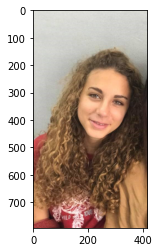

In [0]:
mysisterpic = "../mysister.jpg"
img = mpimg.imread(mysisterpic)
plt.imshow(img)

Now that (1) is done, we're going to jump to (3) before continuing to (2). 
## Building a dataset


In [65]:
!wget https://media.githubusercontent.com/media/metmuseum/openaccess/master/MetObjects.csv

--2020-04-30 13:43:46--  https://media.githubusercontent.com/media/metmuseum/openaccess/master/MetObjects.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275959599 (263M) [text/plain]
Saving to: ‘MetObjects.csv.3’

MetObjects.csv.3    100%[===================>] 263.17M  63.6MB/s    in 4.6s    

2020-04-30 13:44:00 (56.9 MB/s) - ‘MetObjects.csv.3’ saved [275959599/275959599]



In [0]:
import sys
import getopt


We are going to download the images from the MET site. <br>
In order to do so we need the following csv:

In [0]:
import csv
met_csv_file = "MetObjects.csv.3"

Now we have to select the lines in the csv files that correspond to our query. <br>We will query paintings, oil paint and canvas registered before 1900.

In [0]:
met_csv = csv.reader(open(met_csv_file, 'r'), delimiter=',')
lines = [] 
types = ["canvas","oil paint","paintings"]
for row in met_csv:
    if (any(word.lower() in types for word in row)): # filtering based on types ()
      if(row[6]!='' and int(row[6])<1900): # filtering based on year (only before 1900)
        if(row[-2]!='' and "women" in row[-2].lower()): # filtering based on content (only women)
          lines.append(row)

In [34]:
len(lines)

102

Now that we have filtered based on times we can finally download these images.

In [0]:
import os
folder = "./paintings"
if not os.path.exists(folder):
      os.makedirs(folder)

You can skip over the next section where basically I istall selenium and all the necessary tools to scrape the page on the Colab server.

In [0]:
import urllib
import requests

image_names = []
for line in lines: 
  try:
      response = requests.get(line[-6])
      html = response.text
  except Exception as e:
      print(e)
      image_names.append(None)
      continue
  # set the offset to the part of the page where there's the link to the image
  offset = html.find("artwork__interaction artwork__interaction--download")  
  offset = html[offset:].find('http') + offset
  end = html[offset:].find('.jpg') + offset + 4
  # verify it is a valid link
  if (end - offset > 300):
      print("URL Error")
      continue
  # extract the link
  image_link = html[offset:end]
  print(image_link)
  # download the image
  image_name = line[5]
  image_path = os.path.join(folder, image_name)
  try:  
      # save the image
      urllib.request.urlretrieve(image_link, filename=image_path)
      image_names.append(image_path)
  except Exception as e:
      image_names.append(None)
      print(e)
      continue	

In [0]:
lines[0]

In [65]:
requests.get("http://www.metmuseum.org/art/collection/search/10184").text

'<html>\r\n<head>\r\n<META NAME="robots" CONTENT="noindex,nofollow">\r\n<script src="/_Incapsula_Resource?SWJIYLWA=5074a744e2e3d891814e9a2dace20bd4,719d34d31c8e3a6e6fffd425f7e032f3">\r\n</script>\r\n<body>\r\n</body></html>'

In [61]:
!wget https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving/

--2020-04-30 14:40:33--  https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving/
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [ <=>                ] 613.53K  3.30MB/s    in 0.2s    

2020-04-30 14:40:34 (3.30 MB/s) - ‘index.html’ saved [628250]

